# Interactive notebooks

`ipywidgets` provides the Python bindings for interactive elements in Jupyter notebooks.  Bindings for other language to use with non-Python kernels are available as well.

In [1]:
from ipywidgets import interact, interact_manual
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import warnings

## Fast compute

### Example 1: sigmoid function

Define a function that will plot $\tanh(\beta x)$ for $x \in [-5, 5]$ and $\beta > 0$ a parameter value.

In [2]:
def plot_tanh(beta):
    x = np.linspace(-5.0, 5.0, 101)
    y = np.tanh(beta*x)
    _ = plt.plot(x, y)

Now this function can be run for various values of `beta`, e.g.,

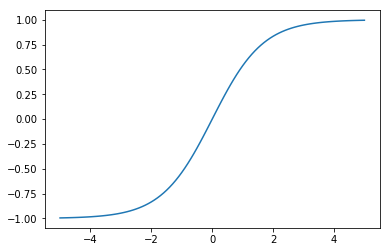

In [3]:
plot_tanh(0.6)

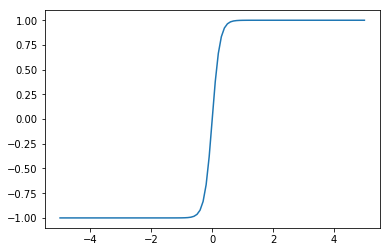

In [4]:
plot_tanh(4.0)

However, it would be much more interesting if the value of `beta` could be modified interactively, the plot modified on the fly.  A simple function decorated with accomplish this easily.

In [5]:
@interact(beta=(0.2, 5.0, 0.2))
def plot_tanh(beta):
    x = np.linspace(-5.0, 5.0, 101)
    y = np.tanh(beta*x)
    _ = plt.plot(x, y)

interactive(children=(FloatSlider(value=2.4000000000000004, description='beta', max=5.0, min=0.2, step=0.2), O…

A plot can be parameterized by multiple values, either numerical or categorical.

### Example 2: viral load

A model for the viral load is given by
$$
V(t) = A e^{-\alpha t} + B e^{-\beta t}
$$
This expression can be rewritten as
$$
V(t) = A e^{-\alpha t} (1 + \frac{B}{A} e^{-(\beta - \alpha)t}
$$
In order to study this function qualitatively, we can set $A = 1$ and $\alpha = 1$.  We know that $-1 \leq B \leq 0$, $1 \leq \beta$, two independent quantities.

In [5]:
@interact(B=(-1.0, 0.0, 0.05), beta=(1.0, 8.0, 0.1))
def viral_load_plot(B, beta):
    t = np.linspace(0.0, 7.0, 101)
    v = np.exp(-t)*(1.0 + B*np.exp(-(beta - 1.0)*t))
    _ = plt.plot(t, v)
    _ = plt.ylim(0.0, 1.0)
    _ = plt.xlabel('$t$')
    _ = plt.ylabel('$V(t)$')

interactive(children=(FloatSlider(value=-0.5, description='B', max=0.0, min=-1.0, step=0.05), FloatSlider(valu…

## Slow compute

### Julia set

Define a function that computes the number of iterations of $z = z^2 + c$ such that $|z| < 2$ in the complex plane.

In [2]:
def compute_fractal(c_re, c_im):
    c = complex(c_re, c_im)
    max_iters = 255
    nr_points = 300
    max_val = 1.8
    max_norm = 2.0
    x = np.linspace(-max_val, max_val, nr_points)
    y = np.linspace(-max_val, max_val, nr_points)
    X, Y = np.meshgrid(x, y)
    Z = X + Y*1j
    iterations = np.zeros(Z.shape, dtype=np.uint8)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for _ in range(max_iters):
            Z = Z**2 + c
            iterations[np.abs(Z) < max_norm] += 1
    return iterations
        

Define a function to plot the result of that function as a heatmap.

In [14]:
def plot_fractal(c_re=-0.62, c_im=0.52):
    ns = compute_fractal(c_re, c_im).astype(np.float32)
    _, axes = plt.subplots()
    axes.imshow(ns/np.max(ns), cmap='RdBu')
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)

You can call this function for various values of the real and imaginary part of $c$.

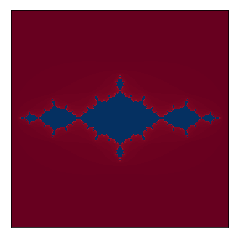

In [15]:
plot_fractal(-0.622772, 0.52193j)

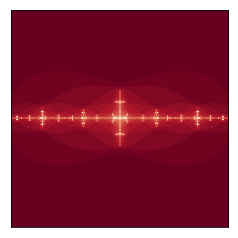

In [16]:
plot_fractal(-0.78, 0.86j)

However, the function takes a while to evaluate.

In [9]:
%timeit compute_fractal(-0.6, 0.4)

606 ms ± 94.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


On average, it takes more than half a second to complete the computation, so making this interactive and just touching the sliders would result in jaggy output (at least).  Hence `interact_manual` is more appropriate, since the computation is only initiated when the `Run interact` button is pressed.

In [17]:
_ = interact_manual(plot_fractal, c_re=(-1.0, 1.0, 0.01), c_im=(-1.0, 1.0, 0.01))

interactive(children=(FloatSlider(value=-0.62, description='c_re', max=1.0, min=-1.0, step=0.01), FloatSlider(…

## Linked plots

In [21]:
import altair as alt
alt.renderers.enable('notebook')
import pandas as pd
from scipy.integrate import ode

The set of ordinary differential equations describing an oscillator with length $l = g$ is given by

$$
\begin{split}
\frac{d\theta}{dt} & = & \omega \\
\frac{d\omega}{dt} & = & -\theta - q\omega + F_D \sin(\Omega_D t)
\end{split}
$$

These equations can be solved using `ode` in the `scipy.integrate` module.  We have to define a function that computes the right-hand side of the equations above.

In [59]:
def func(t, y, q=0.0, F_D=0.0, Omega_D=0.0, linear=True):
    theta, omega = y[0], y[1]
    if linear:
        return [
            omega,
            -theta - q*omega + F_D*np.sin(Omega_D*t)
        ]
    else:
        return [
            omega,
            -np.sin(theta) - q*omega + F_D*np.sin(Omega_D*t)
        ]

We also need to provide the Jacobian of the right-hand sides.

In [60]:
def jac(t, y, q=0.0, F_D=0.0, Omega_D=0.0, linear=True):
    theta, omega = y[0], y[1]
    if linear:
        [[0.0, 1.0],
         [-1.0, -q]]
    else:
        [[0.0, 1.0],
         [-np.cos(theta), -q]]

The function below will integrate the equations in the interval $0 \le t \le t_{\rm max}$.

In [64]:
def solve(t_max=20.0, q=0.0, F_D=0.0, Omega_D=0.0, linear=True, theta0=0.1):
    t, theta, omega = 0.0, theta0, 0.0
    ts, thetas, omegas = [t], [theta], [omega]
    delta_t = 0.01
    system = ode(func, jac).set_integrator('dopri5') \
                           .set_f_params(q, F_D, Omega_D, linear) \
                           .set_jac_params(q, F_D, Omega_D, linear) \
                           .set_initial_value((theta, omega), t)
    while system.successful() and system.t <= t_max:
        system.integrate(system.t + delta_t)
        ts.append(system.t)
        thetas.append(system.y[0])
        omegas.append(system.y[1])
    
    return pd.DataFrame({'t': ts, 'theta': thetas, 'omega': omegas})

The function below will solve and plot the solution to the differential equations.

In [65]:
def solve_plot(t_max=20.0, q=0.0, F_D=0.0, Omega_D=0.0, linear=True, theta0=0.1):
    data = solve(t_max, q, F_D, Omega_D, linear, theta0)
    brush = alt.selection_interval()
    chart = alt.Chart(data).mark_point().encode(
        color=alt.condition(brush, alt.value("black"), alt.value("lightgray")),
        opacity=alt.condition(brush, alt.value(1.0), alt.value(0.2)),
        size=alt.value('1')
    ).add_selection(
        brush
    )
    return chart.encode(x='t:Q', y='theta:Q') | chart.encode(x='theta:Q', y='omega:Q')

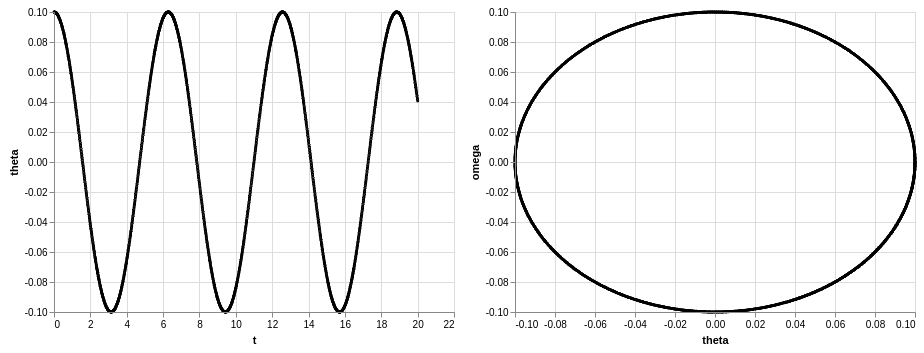

In [62]:
solve_plot()

    This interactive plot can be combined with `ipywidgets` as well.

In [66]:
_ = interact_manual(solve_plot, t_max=(10.0, 45.0, 0.5), q=(0.0, 2.0, 0.1),
                    F_D=(0.0, 2.0, 0.1), Omega_D=(0.0, 2.0*np.pi, 0.1),
                    linear=[False, True], theta0=(0.0, np.pi, 0.05))

interactive(children=(FloatSlider(value=20.0, description='t_max', max=45.0, min=10.0, step=0.5), FloatSlider(…